# Problem formulation of Van der Pol

$$ \min J = \frac{1}{2} \int_0^5 (x_1^2 + x_0^2 + u^2) dt $$

$$ \dot{x}_0 = -x_1 + (1 - x_1^2)x_0 + u ; \hspace{30pt} x_0(0) = 0 $$ 
$$ \dot{x}_1 = x_0 ; \hspace{114pt} x_1(0) = 1 $$
$$ x_1(10) - x_0(10) + 1 = 0 $$

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      158
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      115

Total number of variables............................:       60
                     variables with only lower bounds:       20
                variables with lower and upper bounds:       20
                     variables with only upper bounds:        0
Total number of equality constraints.................:       41
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5049091e-01 1.00e+00 7.01e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

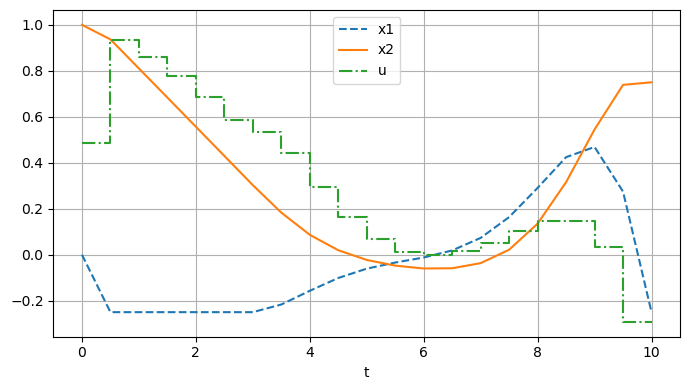

In [19]:
import numpy as np
import importlib
import casadi as ca
import matplotlib.pyplot as plt
import Milestone1 as mil1
importlib.reload(mil1)

T = 10. # Time horizon
N = 20 # number of control intervals

# Declare model variables
x1 = ca.MX.sym('x1')
x2 = ca.MX.sym('x2')
x = ca.vertcat(x1, x2)
u = ca.MX.sym('u')

# Model equations
xdot = ca.vertcat((1-x2**2)*x1 - x2 + u, x1)

# Objective term
L = 0.5*(x1**2 + x2**2 + u**2)

rhs = {'x': x, 'p': u, 'ode': xdot, 'quad': L}

ms = mil1.ms_ocp(rhs, nx=2, N=N, T=T, nu=1)

terminal_eq = [ ms['X'][-1][0] - ms['X'][-1][1] + 1 ]

setup = mil1.add_constraints(
    ms_data      = ms,
    x_bounds     = ([-0.25, -ca.inf], [ca.inf, ca.inf]),
    u_bounds     = (-1, 1),
    extra_eq     = terminal_eq,
    x0_val       = [0, 1],        # fixed initial state
)

solver = ca.nlpsol('solver', 'ipopt', setup['prob'])
sol    = solver(x0=setup['w0'],
                lbx=setup['lbx'], ubx=setup['ubx'],
                lbg=setup['lbg'], ubg=setup['ubg'])

w_opt  = sol['x'].full().flatten()

#------------------------------------------------------------------------------------

states, controls = mil1.unpack_ms_solution(ms, sol)

x1_opt = states[:, 0]
x2_opt = states[:, 1]
u_opt  = controls[:, 0]

tgrid = np.linspace(0, T, N + 1)

u_plot = np.r_[u_opt, np.nan]
#print(u_plot)

plt.figure(figsize=(7, 4))
plt.plot(tgrid, x1_opt, '--', label='x1')
plt.plot(tgrid, x2_opt,  '-', label='x2')
plt.step(tgrid, u_plot,  '-.', where='post', label='u')
plt.xlabel('t')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

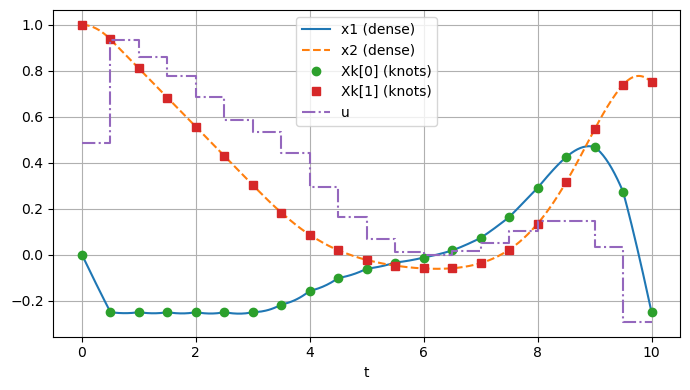

In [20]:
# visual‑check of multiple‑shooting continuity
def plot_ms_trajectory(ms_data, sol, T, N, samples_per_interval=20):
    """
    Visualise the continuous trajectory implied by the multiple‑shooting solution.

    Parameters
    ----------
    ms_data : dict
        Output of `ms_ocp` (contains lists `X`, `U`, and concatenated `w`).
    sol : dict
        Result of the NLP solver (what `nlpsol(... )` returns).
    T : float
        Horizon length.
    N : int
        Number of shooting intervals.
    samples_per_interval : int, default 20
        How many intermediate points to draw *within* each interval.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    dt_small = (T/N) / samples_per_interval
    F = ca.integrator('F_small', 'cvodes', rhs, 0, dt_small)

    # ------ unwrap decision vector into state / control arrays ----------------
    w_opt = sol['x'].full().ravel()
    nx    = ms_data['X'][0].numel()
    nu    = ms_data['U'][0].numel()

    split     = (N + 1) * nx
    states    = w_opt[:split].reshape(N + 1, nx)
    controls  = w_opt[split:].reshape(N, nu)

    # ------ dense reconstruction ---------------------------------------------
    dense_t   = []
    dense_x   = []

    dt = T / N
    for k in range(N):
        # starting point
        x0_opt = states[k]
        u_opt  = controls[k]

        # integrate with *fine* grid
        ts = np.linspace(k * dt, (k + 1) * dt, samples_per_interval + 1)
        x_traj = [x0_opt]

        # CasADi integrator takes only the end‑time; integrate step‑by‑step
        x_curr = x0_opt
        for _ in range(samples_per_interval):
            x_curr = F(x0=x_curr, p=u_opt)['xf'].full().ravel()
            x_traj.append(x_curr)

        dense_t.extend(ts)
        dense_x.extend(x_traj)

    dense_x = np.asarray(dense_x)  # shape (N*samples_per_interval+1, nx)

    # ------ plotting ----------------------------------------------------------
    plt.figure(figsize=(7, 4))

    # smooth curve
    plt.plot(dense_t, dense_x[:, 0], label='x1 (dense)', linestyle='-')
    plt.plot(dense_t, dense_x[:, 1], label='x2 (dense)', linestyle='--')

    # knot points
    knot_t = np.linspace(0, T, N + 1)
    plt.plot(knot_t, states[:, 0], 'o', label='Xk[0] (knots)')
    plt.plot(knot_t, states[:, 1], 's', label='Xk[1] (knots)')

    # controls as step‑hold
    u_plot = np.r_[controls[:, 0], np.nan]
    plt.step(knot_t, u_plot, where='post', linestyle='-.', label='u')

    plt.xlabel('t')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_ms_trajectory(
    ms_data = ms,      # the dict returned by ms_ocp
    sol     = sol,     # result of the solver
    T       = T,
    N       = N,
)